In [1]:
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=30, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
parser.add_argument("--clip_value", type=float, default=0.01, help="lower and upper clip value for disc. weights")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
opt = parser.parse_args(args=[])
print(opt)

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False


Namespace(b1=0.5, b2=0.999, batch_size=64, channels=1, clip_value=0.01, img_size=28, latent_dim=100, lr=0.0002, n_cpu=8, n_critic=5, n_epochs=30, sample_interval=400)


In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [5]:
k = 2
p = 6


# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

In [6]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [7]:
import os

# 在保存图像之前确保文件夹存在
os.makedirs("images-DIV/", exist_ok=True)

# ----------
#  Training
# ----------
LD = []
LG = []
x = []
batches_done = 0
for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor), requires_grad=True)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)

        # Compute W-div gradient penalty
        real_grad_out = Variable(Tensor(real_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        real_grad = autograd.grad(
            real_validity, real_imgs, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        fake_grad_out = Variable(Tensor(fake_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake_grad = autograd.grad(
            fake_validity, fake_imgs, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        div_gp = torch.mean(real_grad_norm + fake_grad_norm) * k / 2

        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + div_gp

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            if (i % len(dataloader))%300==0:
                print(
                    "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                    % (
                        epoch, opt.n_epochs, i % len(dataloader), len(dataloader), d_loss.item(),
                        g_loss.item())
                )

            if batches_done % opt.sample_interval == 0:
                save_image(fake_imgs.data[:25], "images-DIV/%d.png" % batches_done, nrow=5, normalize=True)

            batches_done += opt.n_critic
        LD.append(d_loss.item())
        LG.append(g_loss.item())
        x.append(epoch + 1)


[Epoch 0/30] [Batch 0/938] [D loss: -0.078290] [G loss: 0.044623]
1
[Epoch 0/30] [Batch 300/938] [D loss: -4.113735] [G loss: -5.191248]
1
[Epoch 0/30] [Batch 600/938] [D loss: -4.117727] [G loss: -2.287758]
1
[Epoch 0/30] [Batch 900/938] [D loss: -3.499110] [G loss: -0.686550]
[Epoch 1/30] [Batch 0/938] [D loss: -4.080035] [G loss: 0.465698]
1
[Epoch 1/30] [Batch 300/938] [D loss: -4.907766] [G loss: 1.589069]
[Epoch 1/30] [Batch 600/938] [D loss: -3.641990] [G loss: 0.535768]
1
[Epoch 1/30] [Batch 900/938] [D loss: -3.853525] [G loss: 0.645967]
[Epoch 2/30] [Batch 0/938] [D loss: -3.807473] [G loss: -0.120104]
1
[Epoch 2/30] [Batch 300/938] [D loss: -3.826309] [G loss: 0.139776]
1
[Epoch 2/30] [Batch 600/938] [D loss: -3.011878] [G loss: -0.306596]
[Epoch 2/30] [Batch 900/938] [D loss: -2.997148] [G loss: 0.376866]
1
[Epoch 3/30] [Batch 0/938] [D loss: -2.829202] [G loss: 1.398959]
[Epoch 3/30] [Batch 300/938] [D loss: -3.190344] [G loss: 1.578949]
1
[Epoch 3/30] [Batch 600/938] [D l

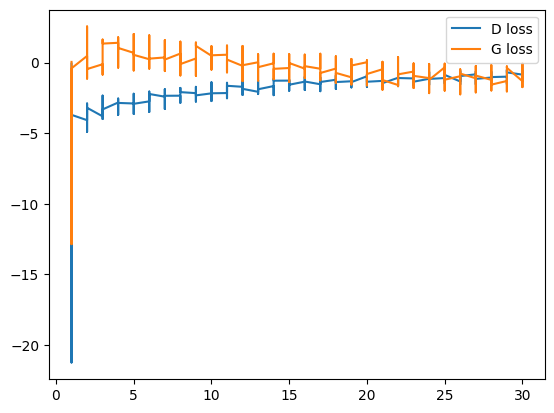

In [8]:
from matplotlib import pyplot as plt
plt.plot(x, LD, label='D loss')
plt.plot(x, LG, label='G loss')
plt.legend()
plt.savefig('test.png')
plt.show()

In [9]:
import zipfile
import os

def zip_folder(folder_path, zip_filename):
    # 创建一个Zip文件对象
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # 遍历文件夹内的所有文件并添加到Zip文件
        for foldername, subfolders, filenames in os.walk(folder_path):
            for filename in filenames:
                file_path = os.path.join(foldername, filename)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# 调用函数，压缩文件夹
folder_to_compress = 'images-DIV'  # 替换为你的文件夹路径
zip_filename = 'images-DIV.zip'  # 替换为你的压缩文件名

zip_folder(folder_to_compress, zip_filename)